# Final Project Submission

Please fill out:
* Student name: **Darius Fuller**
* Student pace: self paced / **part time** / full time
* Scheduled project review date/time: **TBD**
* Instructor name: **James Irving**
* Blog post URL: **https://medium.com/@d_full22/getting-sentimental-2db354e833bc**

# The Problem

> In this project I will be building a NLP model to analyze Twitter sentiment about various Apple and Google products. The end result will be able to look at a tweet and predict whether its underlying sentiment is *negative*, *neutral*, or *positive*.

> The dataset used can be found at this data.world page: [Click here](https://data.world/crowdflower/brands-and-product-emotions)

## The plan

> Although NLP can be achieved with more traditional machine learning models, I want to give this a try using a *Recurrent Neural Network* (RNN) which would be considered a Deep Learning model. I will be doing so through the Tensorflow/Keras packaging.

# Imports

In [1]:
import pandas as pd
import numpy as np
import functions as dlf
import matplotlib.pyplot as plt
import warnings
import string
import regex
np.random.seed(22)
warnings.filterwarnings('ignore')

In [2]:
from importlib import reload
from sklearn.model_selection import train_test_split
from sklearn import metrics
from nltk import word_tokenize, TweetTokenizer, FreqDist
from nltk.corpus import stopwords
from nltk.tokenize.treebank import TreebankWordDetokenizer
from wordcloud import WordCloud, ImageColorGenerator
from os import path
from PIL import Image
from gensim.models import word2vec
from imblearn.over_sampling import SMOTE, RandomOverSampler
# from kerastuner.tuners import RandomSearch
# from kerastuner.engine.hyperparameters import HyperParameters
# from tensorflow.keras import backend as K
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalAveragePooling1D
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from keras.utils import to_categorical

Using TensorFlow backend.


> Originally, when attempting to tune my models, I explored the `kerastuner` API. However, due to time limitations and version compatibility issues, I was unable to implement it successfully. This is one of the things I will come back to later if an opportunity to re-work this problem arises.

## Loading + Null Values

> Luckily, this data was available in a .csv file, meaning I could take advantage of Pandas' methods to easily load the data in to my notebook.

In [3]:
## Loading in raw data + quick check
df = pd.read_csv('judge-1377884607_tweet_product_company.csv', encoding='latin-1')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


> This dataset was *really* easy to plug-and-play with. In addition, one benefit to using ANNs for NLP is that it can learn from the sequence of words in order, meaning that the amount of preprocessing can be minimal prior to modeling begins. 

In [4]:
## Broad-scoped check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
tweet_text                                            9092 non-null object
emotion_in_tweet_is_directed_at                       3291 non-null object
is_there_an_emotion_directed_at_a_brand_or_product    9093 non-null object
dtypes: object(3)
memory usage: 213.2+ KB


> There are just under 2/3 of the data missing for the `emotion_in_tweet_is_directed_at` column. I will not include this for my sentiment analysis but I do think that it could be useful for me later in terms of guessing what product the tweet is talking about.
* Otherwise I only need to address the **one** null value in `tweet_text`.

In [5]:
## Verifying location of null value
df.loc[df['tweet_text'].isna()]

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
6,NaN,NaN,No emotion toward brand or product


In [6]:
## NA removal + sanity check + version control
df_prep = df.drop(index=6, columns='emotion_in_tweet_is_directed_at').copy()
print('Total # of null values by column:')
display(df_prep.isna().sum())

Total # of null values by column:


tweet_text                                            0
is_there_an_emotion_directed_at_a_brand_or_product    0
dtype: int64

> With all of the null values being removed, the next step will be to do a train-test split before modeling.

# EDA - Visuals

> Before I begin modeling, I will take a look at what kind of words are in the dataset as a whole. *Important*: these following will not be used directly in the modeling process, however they will help illustrate what the model is learning from and allow me to use my own thoughts to gain insight from the text.

> I will use NLTK's FreqDist to help show how often specific words appear in the dataset and word clouds to demonstrate this in a visually appealing manner. In order to try and squeeze out some more information, I will create visuals for the entire dataset and each target class respectively.

In [7]:
## Slicing df_prep for each target class
nega_tweets_df = df_prep[df_prep['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Negative emotion'].copy()
posi_tweets_df = df_prep[df_prep['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Positive emotion'].copy()
neut_tweets_df = df_prep[(df_prep['is_there_an_emotion_directed_at_a_brand_or_product'] == 'No emotion toward brand or product')|(df_prep['is_there_an_emotion_directed_at_a_brand_or_product'] == "I can't tell")].copy()

## Setting each into a pandas series
all_tweets_raw = df_prep['tweet_text'].copy()
nega_tweets_raw = nega_tweets_df['tweet_text'].copy()
posi_tweets_raw = posi_tweets_df['tweet_text'].copy()
neut_tweets_raw = neut_tweets_df['tweet_text'].copy()

> After doing some work exploring the tweets individually (see 'Regex Cleaning' section), I was able to determine a few patterns to preempt some irregularities in the text data.

In [8]:
## Removes all things NOT a letter, number, space, or punctuation
patt = r"([^A-Za-z0-9|\s|[:punct:]]*)"
## Removes all words starting with "&" + ending with ";"
patt2 = r"(&\w+;)"
## Removes any words inside [] or {}
patt3 = r"([\[\{]+[A-z]*[\]\}]+)"
## Removes any "@mention"s
patt4 = r"(@+\w{1,7})"
## Removes any case of sxsw and RT 
patt5 = r"(#+sxsw|#+SXSW|RT)"
## Removes punctuation + some special cases
patt6 = r'([!¡÷«»¬©"$£%¢&()*+±,-./:;<=>?@\\^_`´{|}~\t\n]+)'

## Putting all together + using function to sub out patterns with ''
patties = [patt, patt2, patt3, patt4, patt5, patt6]

all_tweets_cln = dlf.regex_cleanse(all_tweets_raw, patties, '')
nega_tweets_cln = dlf.regex_cleanse(nega_tweets_raw, patties, '')
posi_tweets_cln = dlf.regex_cleanse(posi_tweets_raw, patties, '')
neut_tweets_cln = dlf.regex_cleanse(neut_tweets_raw, patties, '')

> First I will start with the entire dataset.

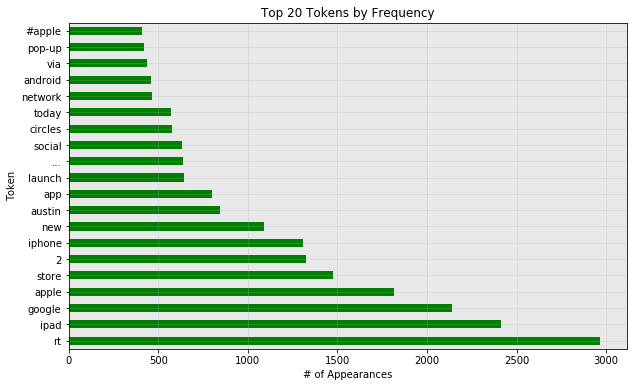

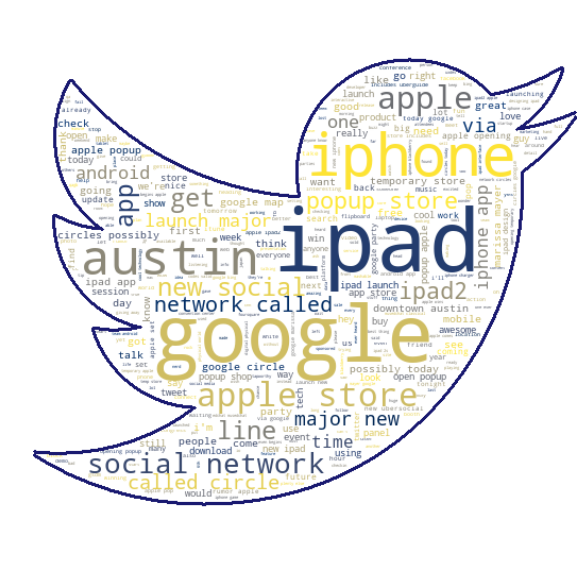

In [9]:
## Storing FreqDist from function + display visuals
all_tweets_fd = dlf.prep_text_visuals(all_tweets_raw, all_tweets_cln, save_path='all_wc.png', keep_fd=True)

> The top 3 most used words are:
* 'rt'
* 'ipad'
* 'google'

> There are some other interesting things such as the appearance of '...', '2', and 'via'. Otherwise the words seem to be inline with that of a tech display at a major festival such as SXSW. I will filter out some of the more non-informative (with regards to sentiment) terms in the following visuals.

In [10]:
## List of extra stopwords to be removed
extra_words = ['2', '...', 'rt', 'austin', 'via']

Stopwords Added: ['2', '...', 'rt', 'austin', 'via']




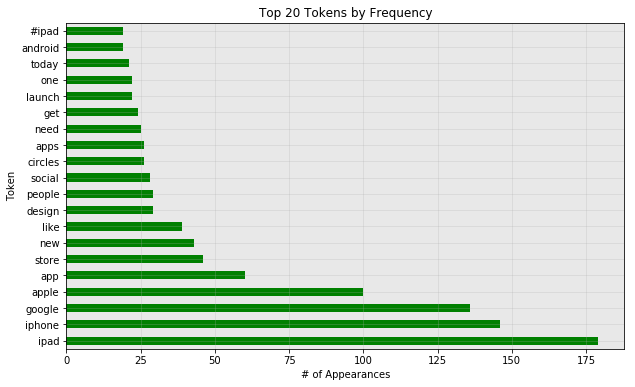

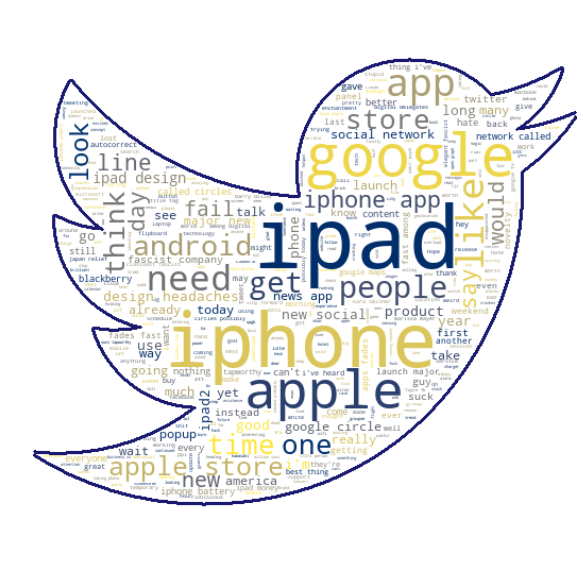

In [11]:
## Visuals for 'negative' tweets
nega_tweets_fd = dlf.prep_text_visuals(nega_tweets_raw, nega_tweets_cln, save_path='nega_wc.png', stopword_extsn=extra_words, keep_fd=True)

> The top *four* words appear at almost 2 times the rate of any other token! 3 of them are Apple related words, along with the word 'app' being the next most frequent word found in negative tweets. Out of these 3, the only phrase that moved higher up in frequency is 'iphone', so it still remains to be seen if these results are due to the entire dataset having a high frequency of these words.

Stopwords Added: ['2', '...', 'rt', 'austin', 'via']




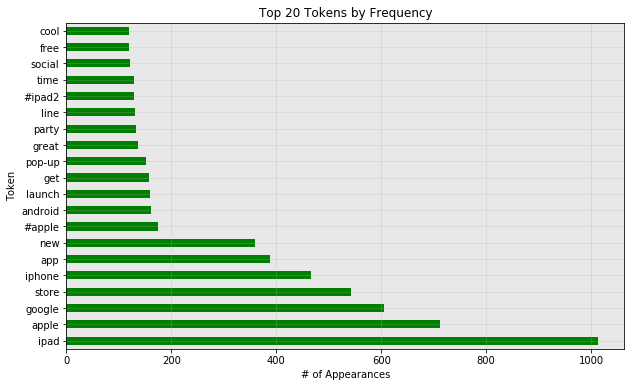

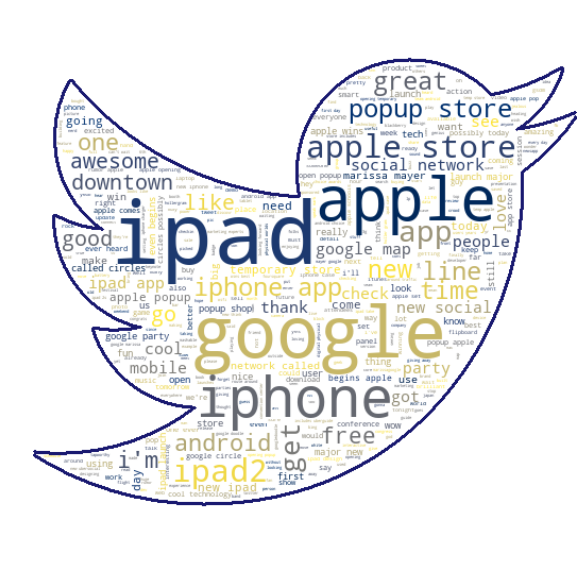

In [12]:
## Visuals for 'positive' tweets
posi_tweets_fd = dlf.prep_text_visuals(posi_tweets_raw, posi_tweets_cln, save_path='posi_wc.png', stopword_extsn=extra_words, keep_fd=True)

> Once again, the top five or so words still are Apple-related. This leads me to believe that is why they were similarly high in the negative tweets. The word 'android' however, does appear more in positive tweets relative to the top 5 than it did in negative tweets.

> In order to alleviate this issue, I will re-run this visuals without product identifying words, hopefully shedding light on more descriptive words.

Stopwords Added: ['2', '...', 'rt', 'austin', 'via']




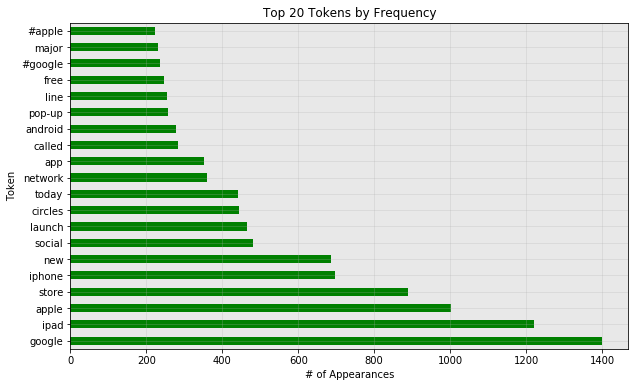

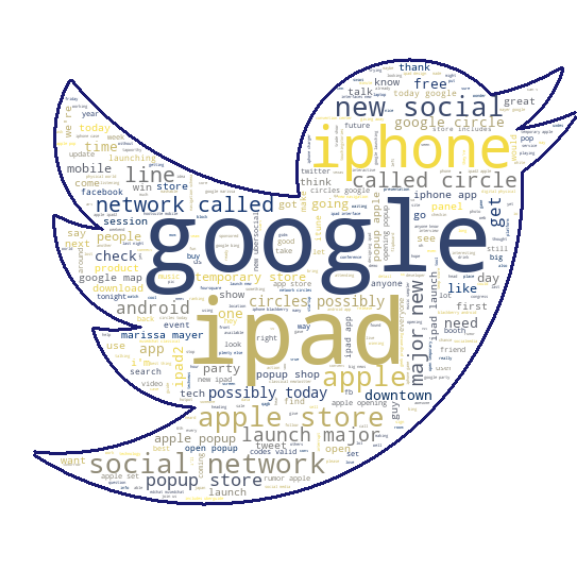

In [13]:
## Visuals for 'neutral' tweets
neut_tweets_fd = dlf.prep_text_visuals(neut_tweets_raw, neut_tweets_cln, save_path='neut_wc.png', stopword_extsn=extra_words, keep_fd=True)

> Once again, very similar to the other's distributions, save a few words moving closer to the top and/or disappearing completely. I will try again without 'Google', 'Apple', 'Android', 'iPad', 'iPhone'.

In [14]:
extra_words2 = ['2', '...', 'rt', 'austin', 'via', 'store', 'google', 'apple', 'android', 'ipad', 'iphone', '#google', '#apple', '#android', '#ipad', '#ipad2', '#iphone', 'w']

Stopwords Added: ['2', '...', 'rt', 'austin', 'via', 'store', 'google', 'apple', 'android', 'ipad', 'iphone', '#google', '#apple', '#android', '#ipad', '#ipad2', '#iphone', 'w']




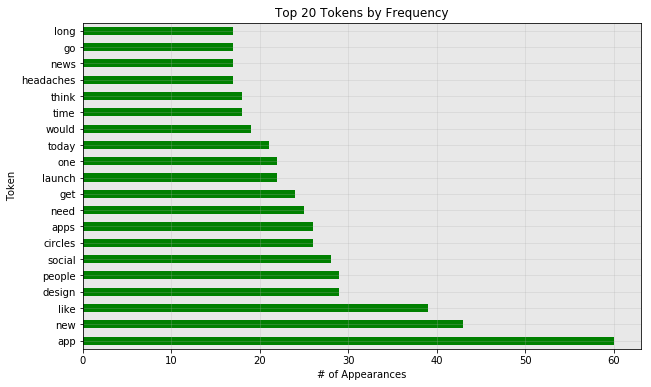

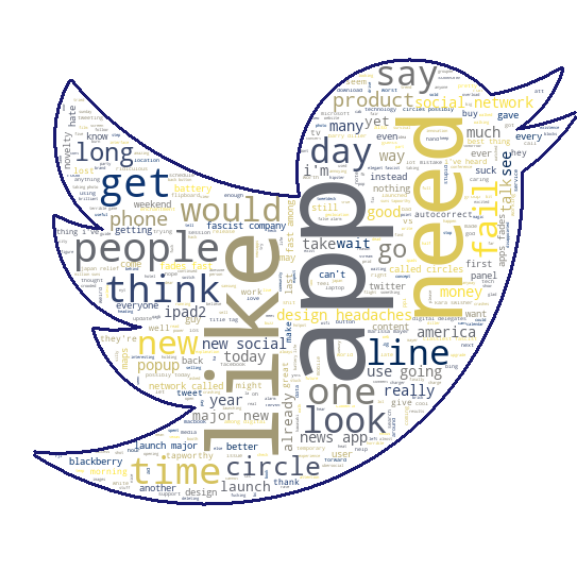

In [15]:
## Visuals for 'negative' tweets
nega_tweets_fd2 = dlf.prep_text_visuals(nega_tweets_raw, nega_tweets_cln, save_path='nega_wc.png', stopword_extsn=extra_words2, keep_fd=True)

Stopwords Added: ['2', '...', 'rt', 'austin', 'via', 'store', 'google', 'apple', 'android', 'ipad', 'iphone', '#google', '#apple', '#android', '#ipad', '#ipad2', '#iphone', 'w']




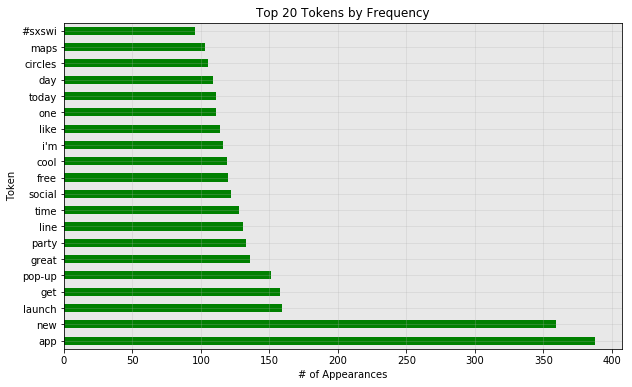

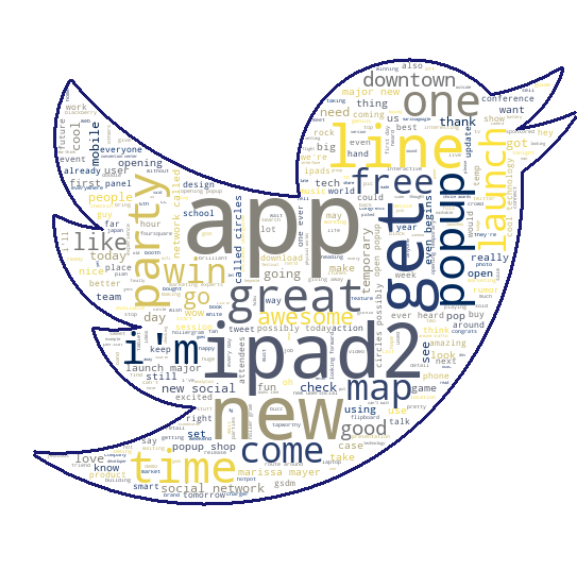

In [16]:
## Visuals for 'positive' tweets
posi_tweets_fd2 = dlf.prep_text_visuals(posi_tweets_raw, posi_tweets_cln, save_path='posi_wc.png', stopword_extsn=extra_words2, keep_fd=True)

# Data Prep

## Train-Test Split

In [17]:
## Creating the variables
X = df_prep['tweet_text'].copy()
y = df_prep['is_there_an_emotion_directed_at_a_brand_or_product'].copy()

> Models require text data to be put into a numerical representation to allow for learning. I need to create a `target` variable for my model to evaluate its performance upon.

In [18]:
## Setting dictionary for which y-values will be mapped to
values = {'No emotion toward brand or product': 1, 'Positive emotion': 2,
          'Negative emotion': 0, "I can't tell": 1}
y = y.map(values)

print('Counts by class:')
y.value_counts()

Counts by class:


1    5544
2    2978
0     570
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [19]:
## Converting pandas series into one-hot encoded 2D array
y_ohe = to_categorical(y)

print("OHE'd target values:")
display(y_ohe)

OHE'd target values:


array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [20]:
## 80/20 Train-test split w/stratify to help with class imbalance + q.c.
X_train, X_test, y_train, y_test = train_test_split(X, y_ohe, test_size=0.2,
                                                    stratify=y, random_state=333)

print('First item in training data:')
X_train[X_train.first_valid_index()]

First item in training data:


'What is google circles?? \x89ÛÏ@mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw\x89Û\x9d'

## Regex Cleaning

> It appears that there needs to be a bit more pre-processing done on these tweets to remove some of the non-language information remaining (`\x89ÛÏ` and `{link}`). I will use the `regex` package to parse through each string and selectively pull out the unwanted information.

In [21]:
## Checking for other things to remove
count = 0
limit = 50
for twt in X_train:
    display(twt)
    count += 1
    
    if count == limit:
        break

'What is google circles?? \x89ÛÏ@mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw\x89Û\x9d'

'Looking for the best iphone app to hail a cab in Austin? (free if possible) #austin #sxsw #iphoneapp'

'Interesting.....RT @mention Google Launching Secret New Social Network Called &quot;Circles&quot; {link} #sxsw'

'If you thought people spent a lot of time staring at their iPhone last year at #sxsw ...just wait.'

'RT @mention #SXSW Come see Bitbop in Austin #gdgtaustin at the PureVolume House\n504 Trinity on Monday, March 14th {link}'

"During Marissa Mayer's presentation at #SXSW they did  a demo of Google maps version 5.2 on mobile and it was pretty impressive."

'Guy Gets Tattooed with Company #Logo to Win an iPad ... {link} #SXSW'

'Google Maps Street View car sighting!!! #SXSW  {link}'

'Check out the new @mention app {link} - this is gonna be HUGE next week at #sxsw and beyond.'

'Scored a signed print of the Jules Verne Google Doodle. Thanks @mention #sxsw #googledoodle {link}'

'Ellen Page appearance reduced to @mention iphone call. Hearts. Broken. #sxsw #super'

'@mention See how many apple men walking around delicious, golden apple, gala, etc. #sxsw'

"Wow. That's dedication RT @mention Well.. I'm first in line. 10.5 hours to go.  #iPad #Apple #SXSW #sleepy"

'I got turkey! RT @mention Random Apple Fan just bought lunch for everyone in line at #SXSW Popup Apple Store #ipad2 cc/ @mention'

'So the phones around me are Blackberry, iphone and android a distant third. #sxsw'

'\x89÷¼ We can\x89Ûªt get no frustration\x89Û_\x89÷_ {link} \x89ã_ #edchat #musedchat #sxsw #sxswi #classical #newTwitter'

'We interrupt your regularly-scheduled #sxsw geek programming with Big news!  {link} by @mention  #google #circles'

'Yes we were RT @mention Apple store downtown Austin open til Midnight. #sxsw'

'An engineer from Google Chrome just came up to correct some misstatements about the browser. Awesome! #payingwithdata #sxsw'

"RT @mention Lonely Planet releases free Austin city guide iPhone app for #SXSW. Like there aren't enough apps cluttering up your handset."

'RT @mention @mention @mention Google to launch social networking site called Circles - soon but not officially at #sxsw {link}'

'RT @mention #sxsw #dvsg &quot;Best chance to disrupt Visa &amp; Master Card are Facebook, Apple (via customers) &amp; mobile carriers (via NFC).&quot;'

'RT @mention By looking around at SXSWi, you would think Apple was the only tech company in existence. #SXSW'

'iPad app content needs to be shallow but engaging #sxsw'

"The long line at the Ginger Man's bathroom just saved me $829. The #SXSW pop-up Apple store closed right at midnight (as I walked up)."

"Congrats to @mention another @mention winner of an #iPad case, it's going on a mission trip with his sister in Haiti! #SXSW #cbatsxsw"

"Good to meet and see all @mention Don't forget: #mindjet giving away an #iPad for best MindManager map of  #SXSWi details: {link}"

'RT @mention The most valuable device at #sxsw so far is the #apple #iPod #iPhone charger.'

"A queue's forming at the Austin #SXSW pop-up Apple store {link} The guy at the front's been there since 5am apparently!"

'Agency people at #sxsw?  This queue if for a pop up ipad store! #savesxsw {link}'

'Starting #sxsw session &quot;Steve Jobs and the Rise of the Techno Priests&quot; #apple'

'Gear list for #SXSW music: iPhone (VZW), Blackberry (Sprint), iPad, Jambox, HP elitebook. Lacking good, portable headphones. Suggestions?'

'#Google Preparing To Launch #SocialMedia \x89ÛÏCircles\x89Û\x9d at #sxsw \x89ÛÓ Or Maybe Not {link} via @mention'

'RT @mention So it appears Apple is opening a pop up store in Austin for #sxsw - the employees were trying to hide it. The Beechwood tables gave it away.'

'Okay, no Google Circles debuting at #sxsw today'

"So went to the Apple Store (Kingston) as friends at #sxsw have new iPad's ... so got something to cheer myself up :) {link}"

'\x89ÛÏ@mention The iPad 2 Takes Over #SXSW [VIDEO]: {link} via Mashable\x89Û\x9d'

'RT @mention Apple opens iPad 2 pop-up store in Austin for #SXSW; could the strategy work for bookselling? {link}'

'Took some video on iPad 2 on 6th street. The smart cover is rad. Filming on the huge display is nuts. Looks great on playback. #sxsw'

'#sxsw (@mention The League of Extraordinary H4ckers Presented By Google w/ 4 others) {link}'

'Saw a company today ready to launch, sounds a lot like Google Circles, but with actual personal privacy www.mycube.com #sxsw'

'RT @mention At #SXSW your iphone charger is your best friend.'

'Just bought a mophie juice pack air rechargeable battery case for my iPhone - this would have come in handy this week #sxsw'

'#tech At #SXSW, Apple schools the marketing experts {link}'

'RT @mention Only at #SxSW: &quot;My iPhone will tell me. You know what that means? #winning&quot; - @mention'

'RT @mention Google TV v 2 be too late, overrun by XBox, PS3, Wii, Netflix and the like; all ready now? #SXSW Barry Diller QA'

'Gonna go see about rockin the Google party like a boss. #sxsw'

'RT @mention &quot;multiple approaches to monetization&quot; re: iPhone game dev &quot;but ads would cheapen our product&quot; ok, good luck with that #sxsw'

'RT @mention RT @mention Location, location location ! {link} via @mention from #google during #sxsw #yam'

"Google's new social network &quot;Circles&quot; being announced today?? #sxsw"

> Although there may be a few special cases left over among the rest of the data, I feel safe targeting the previous two items and will add three more. This means I will be removing:
* `{link}`
* `[VIDEO]`
* `@mention`
* `\x89ÛÏ` and its variants
* `&quot;` and its variants


In [22]:
## Testing on a small sample of the data
tester = X_train.sample(5, random_state=309)

## Removes all things NOT a letter, number, space, or punctuation
patt = r"([^A-Za-z0-9|\s|[:punct:]]*)"
## Removes all words starting with "&" + ending with ";"
patt2 = r"(&\w+;)"
## Removes any words inside [] or {}
patt3 = r"([\[\{]+[A-z]*[\]\}]+)"
## Removes any "@mention"s
patt4 = r"(@+\w{1,7})"
## Visual check to compare
for line in tester:
    print(line, '\n')

Just saw my first iPad 2 user tooÛÓcan tell because he has the white one. #sxsw #apple #iminfanboycentral 

Best thing I've heard in a long while actually! &quot;I gave iPad 2 money to #Japan relief.&quot; #sxsw @mention @mention @mention 

Hmmm RT @mention RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw 

Did Apple deliberately chose March 11 for the iPad 2 availability knowing that a large chunk of their customer base will be at #SXSW? 

RT @mention Hot Pot from Google for mobile maps is a 'very' interesting new app. #sxsw #sxswi 



In [23]:
## Removing each target(s) + saving replacing text
result = dlf.regex_cleaner(tester, patt, '')
result = dlf.regex_cleaner(result, patt2, '')
result = dlf.regex_cleaner(result, patt3, '')
result = dlf.regex_cleaner(result, patt4, '')

## Visual check
for line in result:
    print(line, '\n')

Just saw my first iPad 2 user toocan tell because he has the white one. #sxsw #apple #iminfanboycentral 

Best thing I've heard in a long while actually! I gave iPad 2 money to #Japan relief. #sxsw    

Hmmm RT  RT  Google to Launch Major New Social Network Called Circles, Possibly Today  #sxsw 

Did Apple deliberately chose March 11 for the iPad 2 availability knowing that a large chunk of their customer base will be at #SXSW? 

RT  Hot Pot from Google for mobile maps is a 'very' interesting new app. #sxsw #sxswi 



> It worked! Now to do the *full* training and test data before I tokenize them for the model.

In [24]:
## Creating list for use in function
pattys = [patt, patt2, patt3, patt4]

## Re-assigning cleaner data
X_train = dlf.regex_cleanse(X_train, pattys, '')
X_test = dlf.regex_cleanse(X_test, pattys, '')

## Tokenize + Sequence

> In order to comply with Keras' requirements, I need to re-process the text with their `Tokenizer` class followed by a conversion to a padded sequence.


In [25]:
## Tokenize + convert to padded sequences + custom filter
filt = '!¡÷«»¬©"$£%¢&()*+±,-./:;<=>?@[\\]^_`´{|}~\t\n'
tokenizer = text.Tokenizer(filters=filt)
tokenizer.fit_on_texts(X_train)

> Before any further processing, I want to check on the tokens that my model will be training on. I will do this in a similar fashion, examining the raw frequency counts of each token, accessible via the `word_counts` attribute on Keras' tokenizer.

In [26]:
## Accessing counts
word_c = tokenizer.word_counts

## Dict comprehension sorting by value count descending
word_c = {k:v for k, v in sorted(word_c.items(), key=lambda x: x[1], reverse=True)}

## Unpacking into Dataframe for easier manipulation
word_c_df = pd.DataFrame.from_dict(word_c, orient='index')

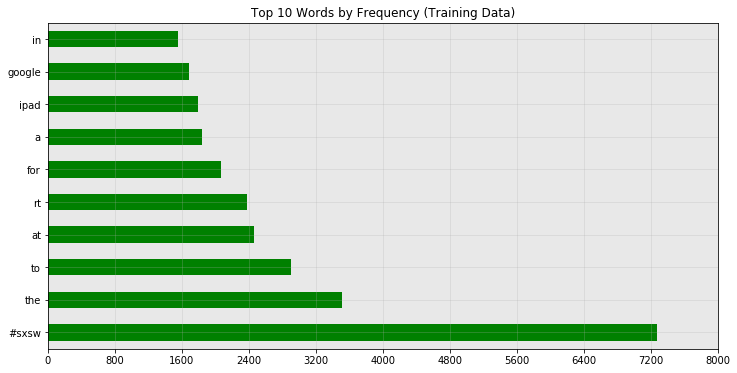

In [27]:
## Figure + ax to plot upon
fig, ax = plt.subplots(figsize=(12,6))

## Pandas plotting w/customization
word_c_df.head(10).plot(kind='barh', color='g', title='Top 10 Words by Frequency (Training Data)', legend=None, ax=ax)
ax.grid(alpha=0.3)
ax.set_facecolor('#e8e8e8')
ax.set_xticks(np.linspace(0, 8000, 11));

> It is obvious that there are *a lot* of stopwords, including the `rt` twitter abbreviation. I do see that `#sxsw` shows up *over* 7,000 times! Initially, I will remove only the `#sxsw` and `rt` in order to try and preserve and sequential information retained in the semantic meanings of the other stopwords. I feel this specific hashtag provides information on the timeframe the tweets were collected and not much on the underlying sentiment within them.

In [28]:
## Removes any case of sxsw and RT 
patt5 = r"(#+sxsw|#+SXSW|RT)"

X_train = dlf.regex_cleaner(X_train, patt5, '')
X_test = dlf.regex_cleaner(X_test, patt5, '')

In [29]:
## To sequences + padding
X_tr_seq = tokenizer.texts_to_sequences(X_train)
X_tr_pad = sequence.pad_sequences(X_tr_seq, maxlen=100)

X_te_seq = tokenizer.texts_to_sequences(X_test)
X_te_pad = sequence.pad_sequences(X_te_seq, maxlen=100)

In [30]:
## Quick check
print('First index item in its sequenced (truncated) and text-form:\n')
display((X_tr_pad[0, 80:100]), (tokenizer.sequences_to_texts([X_tr_seq[0]])))

First index item in its sequenced (truncated) and text-form:



array([ 0,  0,  0,  0,  0, 77, 12,  9, 35,  9,  3, 29, 66, 19, 30, 43, 56,
       35, 85, 32])

['what is google circles google to launch major new social network called circles possibly today']

## Random Over Sampler

> Now that I've addressed the distribution of tokens in the corpus, my next step is to make sure the model has an *equal* chance to learn each target class.

In [31]:
## Q.c of class distribution
print('Class distribution in training data:')
pd.Series(y_train.argmax(axis=1)).value_counts(normalize=True)

Class distribution in training data:


1    0.609790
2    0.327513
0    0.062698
dtype: float64

> I will applying imblearn's ROS (Random Over-Sampler) to address my class imbalance.

> I came to this decision after training some models with the distribution *as-is*. This lead to the models over-fitting quickly to predict class 1 (Neutral emotion). This allowed them to easily achieve higher scores by only predicting this class. There are many options to go with in regards to addressing class imbalances, but I went with ROS due to its method of duplication in the minority classes. This (in theory) will help the model learn in a more balanced manner since overfitting to the majority class will no longer allow for a good accuracy score.

> In addition, since I am dealing with text data, methods such as imblearn's SMOTE will be unable to produce new text data that could be translated into a proper sentence. However, this function is also an advantage of using SMOTE. It helps prevent overfitting due to repetition of the same values created by a method like ROS.

In [32]:
## Applying ROS to address class imbalance
ros = RandomOverSampler(random_state=333)
X_tr_pad_ros, y_tr_ros = ros.fit_resample(X_tr_pad, y_train)

In [33]:
## Q.c of class distribution
print('Class distribution in training data (after balancing):')
pd.Series(y_tr_ros.argmax(axis=1)).value_counts(normalize=True)

Class distribution in training data (after balancing):


2    0.333333
1    0.333333
0    0.333333
dtype: float64

# Building a 'baseline'

## Instantiation

> Now I will build a baseline model to use a reference point for any tweaks I make during the tuning process. This model will include an embedding layer and two hidden layers; one LSTM and one Dense. The output layer will be Dense as well, with the required softmax activation function since we have more than two classes as possible predictions.

> I am choosing an embedding size of 128 as it is a common convention for ANNs performing this kind of task. I will still view this as a tunable parameter.

In [34]:
## Instantiate model + select embedding size
model = Sequential()
embedding_size = 128

## Compilation

> Reasoning for model:
* `LSTM` layer is added to help retain the information intelligently gained from the ordered sequences
* `GlobalAveragePooling1D` is necessary to transform a matrix into a 1-Dimensional representation that is compatible with the following Dense layer
* `Dropout` is added as a regularization measure to aid in generalization of what is learned by the model
* `'relu'` activation function is used to help mitigate exploding/vanishing gradient problem
* `'adam'` optimizer due to its adaptive capabilities with respect to the learning rate
* `'accuracy'` as the metric since I will be looking to correctly identify the sentiment correctly across all classes

In [35]:
## To be added as 'input_dim' for input layer
num_words = X_tr_pad_ros.max() + 1
num_words

## Input layer (input) + dimensions for learning
model.add(Embedding(num_words, embedding_size))

## 1st hidden layer + Pooling to 1d representation + dropout regularization
model.add(LSTM(20, return_sequences=True))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.3))

## 2nd hidden layer + dropout reg.
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.3))

## Output layer 
model.add(Dense(3, activation='softmax'))

## Compliling model to use Adam / accuracy metric
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

## Q.C
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         1200640   
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 20)          11920     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 20)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                

## Training

In [36]:
## Instantiate custom timer class to track training times
t1 = dlf.Timer()

> I am going to add a `validation_split` of 10% of the training data for the model to evaluate each epochs predictions upon before back-propagation. This will hopefully reduce overfitting as well. I also will be using a `batch_size` of 64 as during testing I found this to be the most efficient for my hardware.

In [37]:
## Training!
t1.start()
history1 = model.fit(X_tr_pad_ros, y_tr_ros, batch_size=64, epochs=25, validation_split=0.1, verbose=2)
print('\n')
t1.stop()

Train on 11974 samples, validate on 1331 samples
Epoch 1/25
 - 14s - loss: 1.0695 - accuracy: 0.4307 - val_loss: 1.3043 - val_accuracy: 0.0000e+00
Epoch 2/25
 - 13s - loss: 0.7943 - accuracy: 0.6399 - val_loss: 1.0454 - val_accuracy: 0.0000e+00
Epoch 3/25
 - 13s - loss: 0.6083 - accuracy: 0.7108 - val_loss: 0.7861 - val_accuracy: 0.4703
Epoch 4/25
 - 13s - loss: 0.5086 - accuracy: 0.7743 - val_loss: 0.7261 - val_accuracy: 0.5552
Epoch 5/25
 - 13s - loss: 0.4250 - accuracy: 0.8315 - val_loss: 0.5927 - val_accuracy: 0.7250
Epoch 6/25
 - 13s - loss: 0.3681 - accuracy: 0.8645 - val_loss: 0.5151 - val_accuracy: 0.7791
Epoch 7/25
 - 13s - loss: 0.3265 - accuracy: 0.8796 - val_loss: 0.4342 - val_accuracy: 0.8257
Epoch 8/25
 - 13s - loss: 0.2932 - accuracy: 0.9000 - val_loss: 0.4092 - val_accuracy: 0.8272
Epoch 9/25
 - 13s - loss: 0.2641 - accuracy: 0.9116 - val_loss: 0.3515 - val_accuracy: 0.8527
Epoch 10/25
 - 13s - loss: 0.2460 - accuracy: 0.9182 - val_loss: 0.2778 - val_accuracy: 0.8918
Ep

## Evaluation

> I am going to put the training results into a visualization so that I can get a gauge on how well the training process itself is going.

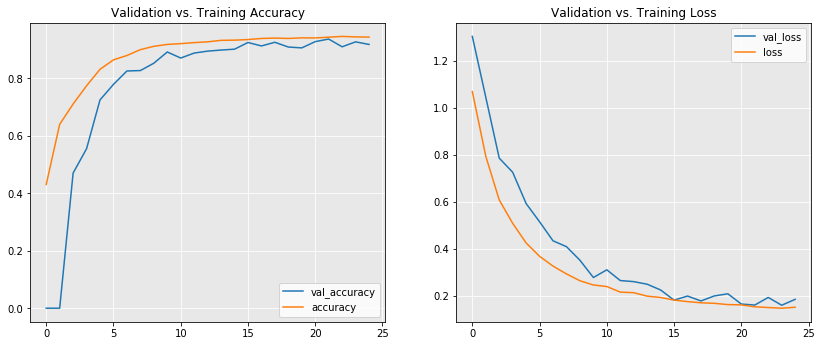

In [38]:
## Figure, axes to plot results
fig, ax = plt.subplots(ncols=2, figsize=(14,5.5))

## Converting metrics in history object to Df for ease of plotting
res_df1 = pd.DataFrame(history1.history)

## Accuracy plot
res_df1[['val_accuracy', 'accuracy']].plot(title='Validation vs. Training Accuracy', ax=ax[0])
ax[0].grid(color='w')
ax[0].set_facecolor('#e8e8e8')

## Loss plot + reveal
res_df1[['val_loss', 'loss']].plot(title='Validation vs. Training Loss', ax=ax[1])
ax[1].grid(color='w')
ax[1].set_facecolor('#e8e8e8')
plt.show();

> Since this is ultimately a classification problem, I will make use of the `classification_report` and `confusion_matrix` functions from Sklearn's metrics module to display and visualize my model's perfomance.

Classification Report:

              precision    recall  f1-score   support

           0       0.32      0.32      0.32       114
           1       0.73      0.74      0.73      1109
           2       0.55      0.52      0.53       596

    accuracy                           0.64      1819
   macro avg       0.53      0.53      0.53      1819
weighted avg       0.64      0.64      0.64      1819



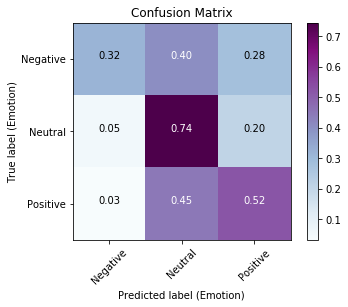

In [39]:
## Create predictions to use with sklearn classif. report
y_hat_te = model.predict(X_te_pad)

## Coercing ohe + probabilities into 1D class predictions 
y_test_cls = y_test.argmax(axis=1)
y_hat_te_cls = y_hat_te.argmax(axis=1)

## Results!
print('Classification Report:\n')
print(metrics.classification_report(y_test_cls, y_hat_te_cls))

## Creating raw normalized conf. matrix
cm = metrics.confusion_matrix(y_test_cls, y_hat_te_cls, normalize='true')

## Setting labels for custom function + display
labels = ['Negative', 'Neutral', 'Positive']
dlf.plot_confusion_matrix(cm, labels)

> **65% accuracy** is a good start! The plots definitely show that the model could learn *even more*. This is demonstrated in how the validation accuracy follows (although fluctuating) the training accuracy as it continues to increase. In addition, the same can be said with respect to the validation loss decreasing in value.

> There is also evidence of overfitting as well. The difference between ~94% training/validation accuracy and 65% testing accuracy is too large to be considered balanced. I may need to look into decreasing complexity or using regularization methods.

> In an effort to help the model address this issue, I will see if using pre-trained word embeddings will help. These embedding layers will not be further trained by my model and hopefully reducing the overfitting.

# Transfer Learning

## Word2Vec

### Tokenizing

> In order to use Word2Vec correctly, I will need to re-tokenize the entire corpus. Word2Vec will allow me to use an embedding layer from which *my model* will use to learn sentiment.

> NLTK offers two different tokenizers I felt could be compared with regards to my model's performance. The first being a generalized function, `word_tokenize()`, and the second being an object with a tokenizer specific to tweets, `TweetTokenizer`.

In [40]:
## Converting tweets into lists of tokens + q.c.
tokens = df_prep['tweet_text'].map(word_tokenize)
print('General Tokenizer:')
display(tokens[:5])

print('\nTweet Tokenizer:')
twt_tkzr = TweetTokenizer(strip_handles=True)
twt_tokens = df_prep['tweet_text'].map(twt_tkzr.tokenize)
display(twt_tokens[:5])

General Tokenizer:


0    [., @, wesley83, I, have, a, 3G, iPhone, ., Af...
1    [@, jessedee, Know, about, @, fludapp, ?, Awes...
2    [@, swonderlin, Can, not, wait, for, #, iPad, ...
3    [@, sxsw, I, hope, this, year, 's, festival, i...
4    [@, sxtxstate, great, stuff, on, Fri, #, SXSW,...
Name: tweet_text, dtype: object


Tweet Tokenizer:


0    [., I, have, a, 3G, iPhone, ., After, 3, hrs, ...
1    [Know, about, ?, Awesome, iPad, /, iPhone, app...
2    [Can, not, wait, for, #iPad, 2, also, ., They,...
3    [I, hope, this, year's, festival, isn't, as, c...
4    [great, stuff, on, Fri, #SXSW, :, Marissa, May...
Name: tweet_text, dtype: object

> In my exploration of these two tokenizers they *do not* have a significant impact on the performance of my models. For sake of brevity I will omit the testing done with `word_tokenize()` and use their object specific to tweets.

### Re-cleaning

> When creating the Word2Vec model that learns the word embeddings, you need to input a `size` parameter that determines the size of the feature vector that will be learned for each word. In order to make sure I use the appropriate value, I need to determine the size of my corpus.

> Additionally, I will want to apply more traditional cleaning techniques to give the pre-trained embeddings the best chance at a good score. Doing so *prior* to determining this size parameter is crucial to ensuring I have the right value.

In [41]:
## Grabbing preset stopword list from nltk 
stop_words = list(stopwords.words('english'))

## Grabbing common punctuation from python + ensuring hashtags survive
punct = list(string.punctuation)
punct.remove('#')

## Cobiming the two lists + specifics to this dataset
stop_words.extend(list(string.punctuation))
stop_words.extend(['#SXSW', '#sxsw', 'RT'])

## Creating new list w/o stopwords + punctuation
twt_tokens_cln = []

for twt in twt_tokens:
    new_twt = [word for word in twt if not word in stop_words]
    twt_tokens_cln.append(new_twt)
    
## Q.C.
print('From Tokenizer:')
print(twt_tokens[33], '\n')
print('Stop words removed:')
print(twt_tokens_cln[33], '\n')

From Tokenizer:
['Anyone', 'at', '#sxsw', 'want', 'to', 'sell', 'their', 'old', 'iPad', '?'] 

Stop words removed:
['Anyone', 'bought', 'new', 'iPad', 'want', 'sell', 'older', 'iPad'] 



> Although my internet research proved conclusive in determining any proper heuristics, there is some [work](https://www.aclweb.org/anthology/I17-2006/) suggesting general guidelines. Having over 13,000 tokens to deal with, I will use a size of 50 in my Word2Vec model.

In [42]:
## Creating a container for 'for' loop
vocab = []

## Add each word, if not in container, from each tweet 
for twt in twt_tokens_cln:
    for word in twt:
        if not word in vocab:
            vocab.append(word)

## Q.C
tot_vocab = len(set(vocab))
print('Total amount of words in corpus:')
print(tot_vocab)

Total amount of words in corpus:
13141


> Next I need to figure out an appropriate window size to use. Determining the average length of my cleaned tokens will help me determine this.

***********************

> **Side-note** I manually will remove a tweet that with mostly non-english tokens to help manage the distribution. I will show that tweet and how I removed it.

In [43]:
for i, twt in enumerate(twt_tokens_cln):
    if len(twt) > 60:
        print('Index:', i, '\n', twt)
        
twt_tokens_cln[1462] = ['Get', 'look', "#SXSW's", 'rumored', '#Apple', 'pop-up', 'store', 'Austin', 'link']
twt_tokens_cln[1462]

Index: 1462 
 ['\x8b', '\x81', '\x8b', 'Ä_', '\x8b', 'Û', '\x81', '\x8b', 'â', '\x8f', '\x8b', '\x81', 'Ü', '\x8b', 'â_', '\x8b', 'âã', '\x8b', '\x81', 'ª', '\x8b', '\x81', 'ã', '\x95', '\x81', '\x8b', 'â', '»', '\x8b', 'Ä_', '\x8b', 'â_', '\x8b', 'Ä', '\x8b', 'â', '£', '\x8b', 'Ä_', '\x8b', '\x81', 'Ç', '\x8f', 'ÁÎ', '\x8b', '\x81', '\x8d', '\x8b', '\x81', 'Ù', '\x8b', '\x81', 'ã', '\x8b', '\x81', '¬', '¾Û', '\x9d', '\x8b', 'â', '\x8f', '\x8b', '\x81', '»', '\x8b', '\x81', 'ã', '\x8b', '\x81', 'Ô', '\x8b', '\x81', '©', '\x8b', 'ÛâRT', 'Get', 'look', "#SXSW's", 'rumored', '#Apple', 'pop-up', 'store', 'Austin', 'link']


['Get',
 'look',
 "#SXSW's",
 'rumored',
 '#Apple',
 'pop-up',
 'store',
 'Austin',
 'link']

************************

In [44]:
## Creating container
twt_lens = [['Tweet_length']]

## Compiling length of each tweet
for twt in twt_tokens_cln:
    twt_lens.append(len(twt))

## Storing in a df + Q.C.    
twt_len_df = pd.DataFrame(twt_lens[1:], columns=twt_lens[0])
display(twt_len_df.head())
twt_len_avg = twt_len_df.agg('mean')
print('Average Tweet length:', twt_len_avg[0])

,Tweet_length
0,14
1,13
2,7
3,8
4,14


Average Tweet length: 11.154421469423669


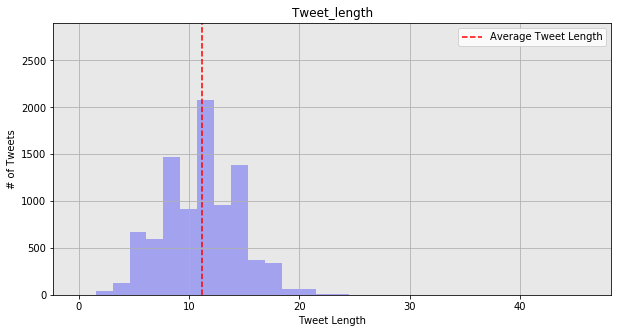

In [45]:
## Storing figure, axes into objects
fig, ax = plt.subplots(figsize=(10,5))

## Pandas historgram
twt_len_df.hist(bins=30, color='b', alpha=0.3, ax=ax)

## Vertical line for avg. length
plt.vlines(twt_len_avg, 0, 2900, color='r', linestyles='dashed', label='Average Tweet Length')

## Styling
plt.ylim(0,2900)
ax.set(xlabel='Tweet Length', ylabel='# of Tweets')
ax.set_facecolor('#e8e8e8')
plt.legend();

> Most tweets available having on average 11 tokens and no more than 20. Thus, I will use a window of 5 so that some of the shorter tweets will still have an opportunity to provide information to the model.

### Vectorizing

In [46]:
## Creating + training 'model'
w2v_t_mod = word2vec.Word2Vec(twt_tokens_cln, size=50, window=5, min_count=1, workers=4)
w2v_t_mod.train(twt_tokens_cln, total_examples=w2v_t_mod.corpus_count, epochs=40)

(3527865, 4056640)

In [47]:
## Retrieving word vectors from 'model' + Q.C.
wv_t = w2v_t_mod.wv
wv_t.similar_by_word('bad')

[('really', 0.6854878664016724),
 ("Doesn't", 0.6696673631668091),
 ('Nah', 0.6626466512680054),
 ('forgot', 0.6615070104598999),
 ('6.5', 0.6566199064254761),
 ('Should', 0.6519976854324341),
 ("dosen't", 0.6467044353485107),
 ('wish', 0.6437498331069946),
 ('#csuitecsourcing', 0.6386643648147583),
 ('Hoping', 0.6380600929260254)]

In [48]:
## Word math to judge relationships
wv_t.most_similar(positive=['phone', 'Apple'])

[('tablets', 0.6439864635467529),
 ('Pair', 0.6267223358154297),
 ('everywhere', 0.6211045980453491),
 ('#nptech', 0.6210685968399048),
 ('intern', 0.6107068061828613),
 ('mistakenly', 0.6098729372024536),
 ('literally', 0.5953028202056885),
 ('829', 0.5928003787994385),
 ('cigarettes', 0.5869834423065186),
 ("Man's", 0.5866082906723022)]

### TT Split + Sequence + ROS

> In order to ensure the best results for my model, I need to re-tool the training data to match that of the 'more clean' data fed into the Word2Vec model. I will leverage the `twt_tokens_cln` and `y_ohe` variables made earlier.

In [49]:
## 80/20 Train-test split w/stratify to help with class imbalance + q.c.
X_tr_cln, X_te_cln, y_tr_cln, y_te_cln = train_test_split(twt_tokens_cln, y_ohe,
                                                          test_size=0.2, stratify=y,
                                                          random_state=333)

In [50]:
## Tokenize + convert to padded sequences
tokenizer_2 = text.Tokenizer()
tokenizer_2.fit_on_texts(X_tr_cln)

X_tr_seq_cln = tokenizer_2.texts_to_sequences(X_tr_cln)
X_tr_pad_cln = sequence.pad_sequences(X_tr_seq_cln, maxlen=100)

X_te_seq_cln = tokenizer_2.texts_to_sequences(X_te_cln)
X_te_pad_cln = sequence.pad_sequences(X_te_seq_cln, maxlen=100)

## Q.c of class distribution
print('Class distribution in training data:')
pd.Series(y_tr_cln.argmax(axis=1)).value_counts(normalize=True)

Class distribution in training data:


1    0.609790
2    0.327513
0    0.062698
dtype: float64

In [51]:
## ROS-ing
ros2 = RandomOverSampler(random_state=333)
X_tr_pad_cln_ros, y_tr_cln_ros = ros2.fit_resample(X_tr_pad_cln, y_tr_cln)

## Q.c of class distribution
print('Class distribution in training data (after balancing):')
pd.Series(y_tr_cln_ros.argmax(axis=1)).value_counts(normalize=True)

Class distribution in training data (after balancing):


2    0.333333
1    0.333333
0    0.333333
dtype: float64

### Training

> For sake of space, I have condensed my code into two custom functions with **tunable parameters**:
* `make_model()`: Builds and compiles a Keras ANN with the same architecture as my baseline model (default setting)
* `evaluate_model()`: Fits, predicts, prints, and visualizes the results of a pre-compiled Keras model. Has an option to return the history directly 

In [52]:
## Ensures functions work properly
reload(dlf)

<module 'functions' from 'C:\\Users\\d_ful\\Documents\\GitHub\\Mod4_Proj\\functions.py'>



Using Pre-Trained Embedding!


------------------------------------------------------------
Model Summary:
------------------------------------------------------------
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 50)          656500    
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 20)          5680      
_________________________________________________________________
global_average_pooling1d_2 ( (None, 20)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                210       
_________________________________________________________________
dropout_4 (Dropo

None

------------------------------------------------------------
Model Training....
------------------------------------------------------------
Train on 9313 samples, validate on 3992 samples
Epoch 1/50
 - 7s - loss: 1.0782 - accuracy: 0.4402 - val_loss: 1.2612 - val_accuracy: 0.0000e+00
Epoch 2/50
 - 7s - loss: 1.0628 - accuracy: 0.4758 - val_loss: 1.2603 - val_accuracy: 0.0000e+00
Epoch 3/50
 - 7s - loss: 1.0557 - accuracy: 0.4762 - val_loss: 1.2672 - val_accuracy: 0.0000e+00
Epoch 4/50
 - 7s - loss: 1.0450 - accuracy: 0.4762 - val_loss: 1.3182 - val_accuracy: 0.0000e+00
Epoch 5/50
 - 7s - loss: 1.0264 - accuracy: 0.4798 - val_loss: 1.2731 - val_accuracy: 0.1293
Epoch 6/50
 - 7s - loss: 1.0000 - accuracy: 0.5153 - val_loss: 1.2237 - val_accuracy: 0.2510
Epoch 7/50
 - 7s - loss: 0.9664 - accuracy: 0.5462 - val_loss: 1.1873 - val_accuracy: 0.2883
Epoch 8/50
 - 7s - loss: 0.9384 - accuracy: 0.5702 - val_loss: 1.1547 - val_accuracy: 0.3131
Epoch 9/50
 - 7s - loss: 0.9088 - accuracy: 0.5887 

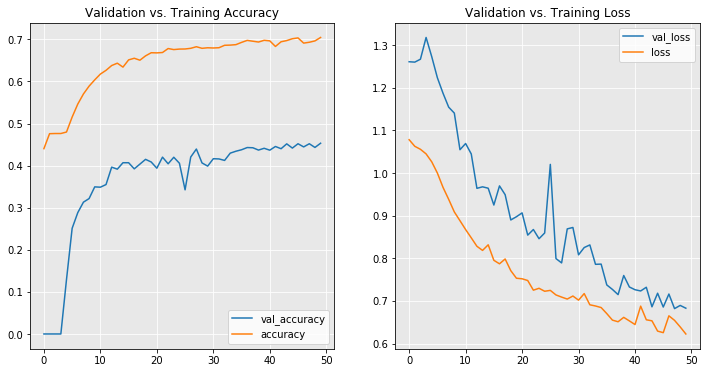

------------------------------------------------------------
Confusion Matrix:
------------------------------------------------------------


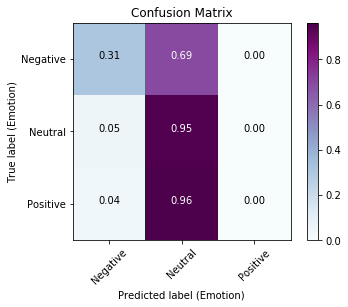

------------------------------------------------------------
Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.32      0.31      0.32       114
           1       0.62      0.95      0.75      1109
           2       0.00      0.00      0.00       596

    accuracy                           0.60      1819
   macro avg       0.31      0.42      0.36      1819
weighted avg       0.40      0.60      0.48      1819



In [53]:
model_w2v_twt = dlf.make_model(cust_emb=wv_t.get_keras_embedding())
dlf.evaluate_model(model_w2v_twt, X_tr_pad_cln_ros, X_te_pad_cln, y_tr_cln_ros, y_te_cln, dlf.Timer, cls_labels=labels, epch=50)

> My model is overfitting, however with worse performance than that of my baseline model that trained the word embeddings during the overall process.

## GloVe

> Similar to Word2Vec, GloVe has two different pre-trained embeddings that can be used. One is for general use and the other for Twitter; I will be showing the latter despite testing both initially.

> One must download the embeddings directly from the glove website, then decide which set to import based upon the amount of dimensions in the pre-trained vectors. Due to hardware limitations, it worked quicker and more consistently with 50-dimensions although they offer up to 200-dimensions.

### Importing Vectors

In [54]:
## https://nlp.stanford.edu/projects/glove/
## Need to download separately and put in directory 1st

filep = '\\Users\d_ful\Documents\Personal\DataSci\Learn.co\Curriculum_2.1\Mod4\Project4\glove.twitter.27B.50d.txt'
tot_vocab = tokenizer_2.word_index
glove_twt = {}
with open(filep, 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in tot_vocab:
            vector = np.array(parts[1:], dtype=np.float32)
            glove_twt[word] = vector
f.close()

In [55]:
## 1st dimension for matrix (# of words)
num_words_t = max(tot_vocab.values()) + 1

## Creating 50d matrix to be filled by WVs
emb_matrix_twt = np.zeros((num_words_t, 50))

## Iteration through tupled information
for word, i in tokenizer_2.word_index.items():
    emb_vector_twt = glove_twt.get(word)

    if emb_vector_twt is not None:
        emb_matrix_twt[i] = emb_vector_twt

### Training

In [56]:
reload(dlf)

<module 'functions' from 'C:\\Users\\d_ful\\Documents\\GitHub\\Mod4_Proj\\functions.py'>



Using Pre-Trained Embedding!


------------------------------------------------------------
Model Summary:
------------------------------------------------------------
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 50)           481150    
_________________________________________________________________
lstm_3 (LSTM)                (None, 100, 20)           5680      
_________________________________________________________________
global_average_pooling1d_3 ( (None, 20)                0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                210       
_________________________________________________________________
dropout_6 (Dropo

None

------------------------------------------------------------
Model Training....
------------------------------------------------------------
Train on 9313 samples, validate on 3992 samples
Epoch 1/50
 - 7s - loss: 1.0672 - accuracy: 0.4695 - val_loss: 1.2570 - val_accuracy: 0.0000e+00
Epoch 2/50
 - 7s - loss: 1.0390 - accuracy: 0.4779 - val_loss: 1.2876 - val_accuracy: 0.0000e+00
Epoch 3/50
 - 7s - loss: 0.9973 - accuracy: 0.5065 - val_loss: 1.2136 - val_accuracy: 0.1696
Epoch 4/50
 - 7s - loss: 0.9571 - accuracy: 0.5327 - val_loss: 1.1495 - val_accuracy: 0.2906
Epoch 5/50
 - 7s - loss: 0.9239 - accuracy: 0.5544 - val_loss: 1.0487 - val_accuracy: 0.4316
Epoch 6/50
 - 7s - loss: 0.8907 - accuracy: 0.5770 - val_loss: 1.0765 - val_accuracy: 0.4161
Epoch 7/50
 - 7s - loss: 0.8656 - accuracy: 0.5871 - val_loss: 0.9897 - val_accuracy: 0.4882
Epoch 8/50
 - 7s - loss: 0.8352 - accuracy: 0.6086 - val_loss: 0.9216 - val_accuracy: 0.5514
Epoch 9/50
 - 7s - loss: 0.8116 - accuracy: 0.6346 - val_lo

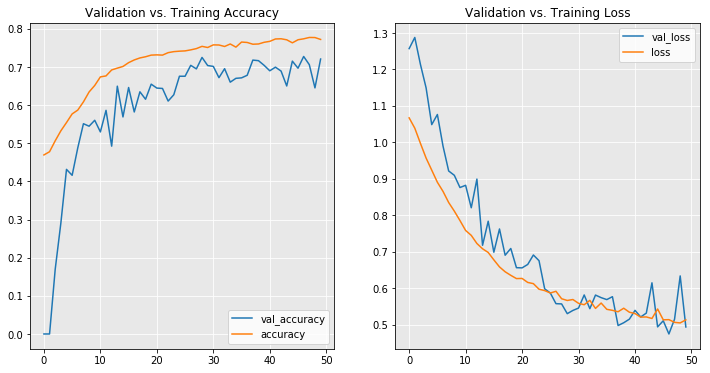

------------------------------------------------------------
Confusion Matrix:
------------------------------------------------------------


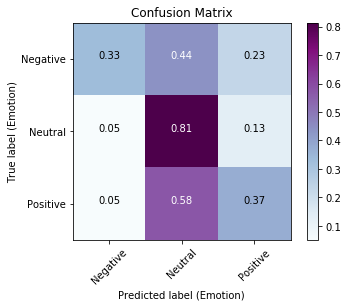

------------------------------------------------------------
Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.30      0.33      0.32       114
           1       0.70      0.81      0.75      1109
           2       0.56      0.37      0.45       596

    accuracy                           0.64      1819
   macro avg       0.52      0.51      0.51      1819
weighted avg       0.63      0.64      0.62      1819



In [57]:
## Presetting embedding layer + training
glve_emb_twt = Embedding(num_words_t, 50, weights=[emb_matrix_twt], input_length=100, trainable=False)

model_glve_twt = dlf.make_model(cust_emb=glve_emb_twt)
dlf.evaluate_model(model_glve_twt, X_tr_pad_cln_ros, X_te_pad_cln, y_tr_cln_ros, y_te_cln, dlf.Timer, cls_labels=labels, epch=50)

> This seems as-if it will continue to improve, but it is apparent that both curves are flattening. Additionally, the accuracy graph indicates there is overfitting occurring. Test accuracy have not improved over the baseline either.

# Final Setup

## NN Architecture

> After many iterations I came across this architecture as the *best* model in relation to the baseline's model performance.

In [58]:
reload(dlf)

<module 'functions' from 'C:\\Users\\d_ful\\Documents\\GitHub\\Mod4_Proj\\functions.py'>

In [61]:
## Instantiate
model_fin = Sequential()

## To be added as 'input_dim' for input layer
num_words_fin = X_tr_pad_cln_ros.max() + 1
print('Highest Seq #:')
print(num_words_fin)

## Embedding size of 64 for memory's sake
embedding_size_fin = 64

## Input layer (input) + dimensions for learning (64)
model_fin.add(Embedding(num_words_fin, embedding_size_fin))

## 1st hidden layer + Pooling to 1d representation + dropout regularization
model_fin.add(LSTM(32, activation='relu', kernel_initializer='glorot_normal', return_sequences=True))
model_fin.add(GlobalAveragePooling1D())
model_fin.add(Dropout(0.3))

## 3rd hiddenn layer + dropout reg.
model_fin.add(Dense(16, activation='relu'))
model_fin.add(Dropout(0.3))

## Output layer 
model_fin.add(Dense(3, activation='softmax'))

## Compliling model to use Adam / accuracy metric
model_fin.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

## Q.C
model_fin.summary()

Highest Seq #:
9623
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 64)          615872    
_________________________________________________________________
lstm_5 (LSTM)                (None, None, 32)          12416     
_________________________________________________________________
global_average_pooling1d_5 ( (None, 32)                0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_10 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None

## Training

------------------------------------------------------------
Model Training....
------------------------------------------------------------
Train on 10644 samples, validate on 2661 samples
Epoch 1/100
 - 11s - loss: 1.0763 - accuracy: 0.4399 - val_loss: 1.2400 - val_accuracy: 0.0722
Epoch 2/100
 - 10s - loss: 0.9872 - accuracy: 0.5701 - val_loss: 1.1713 - val_accuracy: 0.1627
Epoch 3/100
 - 10s - loss: 0.8022 - accuracy: 0.6695 - val_loss: 1.0956 - val_accuracy: 0.1879
Epoch 4/100
 - 10s - loss: 0.6763 - accuracy: 0.7090 - val_loss: 1.0157 - val_accuracy: 0.2011
Epoch 5/100
 - 10s - loss: 0.6090 - accuracy: 0.7352 - val_loss: 0.8127 - val_accuracy: 0.3405
Epoch 6/100
 - 10s - loss: 0.5303 - accuracy: 0.7665 - val_loss: 0.7306 - val_accuracy: 0.4408
Epoch 7/100
 - 10s - loss: 0.4741 - accuracy: 0.7993 - val_loss: 0.6203 - val_accuracy: 0.5641
Epoch 8/100
 - 10s - loss: 0.3983 - accuracy: 0.8365 - val_loss: 0.6118 - val_accuracy: 0.6250
Epoch 9/100
 - 10s - loss: 0.3574 - accuracy: 0.85

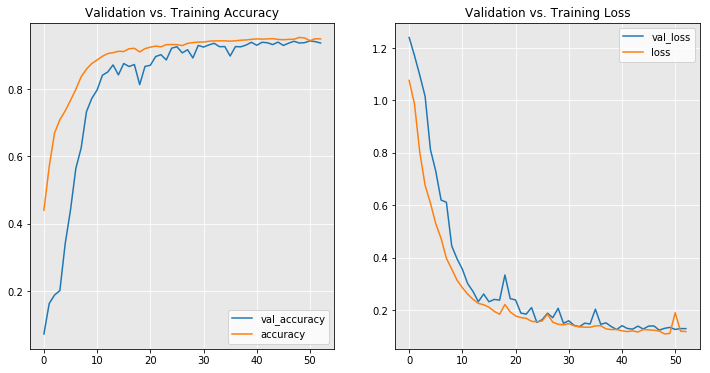

------------------------------------------------------------
Confusion Matrix:
------------------------------------------------------------


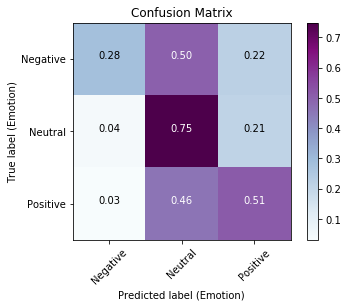

------------------------------------------------------------
Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.33      0.28      0.30       114
           1       0.72      0.75      0.73      1109
           2       0.54      0.51      0.53       596

    accuracy                           0.64      1819
   macro avg       0.53      0.51      0.52      1819
weighted avg       0.64      0.64      0.64      1819



In [62]:
## Training! + eval.
early_stop = [EarlyStopping(monitor='val_accuracy', patience=20, min_delta=0.01)]

dlf.evaluate_model(model_fin, X_tr_pad_ros, X_te_pad, y_tr_ros, y_test, dlf.Timer, cls_labels=labels, epch=100, callb=early_stop, val_split=0.2)

> My final results did not improve over my baseline. Although there are a few differences in their respective classification reports, given more time and data, this could easily be changed. It may be possible to do without altering the structure of the network. I do feel that given how many different architectures I tried during testing, that some different choices during the preprocessing stage may yield better results.

# Recommendations & Future Works

## Recommendations

> I would recommend to any party looking to learn from this analysis, specifically those in the tech field to keep in mind their customer's:
* Time
* Interactions
* Cost (social or financial)

> The frequency in which words pertaining to these ideas showed up very often among the negative and positive tweets collected. For example, the word 'design' showed up often in negative tweets, demonstrating how important any products' *overall design* is to public reception. Additionally, the words 'free', 'pop-up', and 'party' appeared often in positive tweets. This hints towards a customer base that values *free*, spontaneous party-like events or demonstrations, regardless of the product.

> Given these results this model *as-is* does its best work determining which tweets are either 'Positive' *or* 'Negative'. When the model made its predictions, it was more likely the those predictions were a true 'Negative' or 'Positive' tweet than when it predicted a tweet was 'Neutral'. 
* For any 'Negative' prediction it made on the test data, there was only a 6% chance it was either 'Positive' or 'Neutral' in reality, respectively.
* Similarly, for 'Positive' predictions there was a 18-19% chance it was each of the other classes.

> The most improvement that can be made within my model can be in distinguishing those statements 'in-the-middle'. Based upon the results, it is misclassifying primarily in the 'Neutral' column. This means that some 'Negative' tweets carry some different underlying pattern that my model determines to be more neutral than others. It, as alluded to before, misses 43% of its predictions on true 'Negative' tweets by choosing the 'Neutral' class. This can also be said about true 'Positive' tweets. 
* Otherwise, this model is able to achieve 75% inter-class accuracy within the 'Neutral' class. Meaning it can be effective in weeding out these tweets, but it would be at the expense of losing just under 50% of your non-'Neutral' tweets.

## Future Works

> Given more time I would like to explore a few different avenues.
* More Data!
  * One of the reasons my validation accuracy could be improved is by feeding it more examples to learn from.
* More time with NN architectures
  * I found that many different setups can produce similar results, and with so many knobs to turn, maybe there is something else I missed.
* Standard ML methods
  * Perhaps this problem can adequately be handled by a more traditional ML classifier such as RandomForest or Logistic Regression.